In [36]:
import pandas as pd
import numpy as np 
from datetime import timedelta
import os
import sys
sys.path.append('../lib/')
from utils import *
from analysis import * 
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.metrics import mean_squared_error as mse

In [2]:
data = pd.read_csv("../Data/daneOkresoweKSE.csv", sep=';', 
                   skiprows=1, names=['Date', 'Hour', 'Minute', 'Load'])
Electric = data.copy()
Electric['Date'] = pd.to_datetime(Electric.Date)
Electric.loc[Electric.Hour == 24, 
             'Date'] = Electric.loc[Electric.Hour == 24, 'Date'] + timedelta(days=1)
Electric.loc[Electric.Hour == 24, 'Hour'] = 0
Electric.Date = pd.to_datetime(Electric.Date.astype(str) + ' ' + 
                               Electric['Hour'].astype(str) + ':' + 
                               Electric.Minute.astype(str) + ':00')

Electric = Electric[['Date', 'Load']]
Electric['Minutes'] = Electric['Date'].dt.minute
Electric['Hour'] = Electric['Date'].dt.hour

<AxesSubplot:>

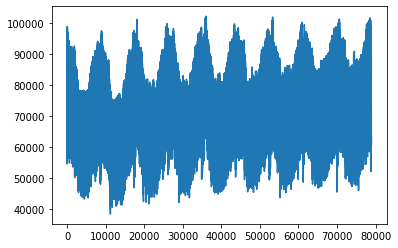

In [3]:
df = resampling_data(Electric)

df = df[~df.Load.isna()].reset_index(drop=True)
df['Load'].plot()

In [4]:
df['Load_lin'] = linear_fit(x=df.index, y=df.Load)
df['Load_detrend'] = df.Load - df['Load_lin']

df

,Date,Hour,Minutes,Load,Day,Holiday,Day id,Load_lin,Load_detrend
0,2008-01-01 01:00:00,1.0,22.5,60819.9,1,True,1,68781.328648,-7961.428648
1,2008-01-01 02:00:00,2.0,22.5,57869.8,1,True,1,68781.407929,-10911.607929
2,2008-01-01 03:00:00,3.0,22.5,55672.8,1,True,1,68781.487211,-13108.687211
3,2008-01-01 04:00:00,4.0,22.5,55331.7,1,True,1,68781.566492,-13449.866492
4,2008-01-01 05:00:00,5.0,22.5,54527.0,1,True,1,68781.645773,-14254.645773
...,...,...,...,...,...,...,...,...,...
78907,2016-12-31 20:00:00,20.0,22.5,70390.3,5,False,366,75037.169791,-4646.869791
78908,2016-12-31 21:00:00,21.0,22.5,66925.1,5,False,366,75037.249072,-8112.149072
78909,2016-12-31 22:00:00,22.0,22.5,64900.1,5,False,366,75037.328354,-10137.228354
78910,2016-12-31 23:00:00,23.0,22.5,63019.8,5,False,366,75037.407635,-12017.607635


In [5]:
x_notrend = df['Load_detrend'].to_numpy()
n = x_notrend.size
n_harm = 10

x_freqdom = np.fft.fft(x_notrend)   # signal in frequencies domain
f = np.fft.fftfreq(n)               # frequencies

indexes = list(range(n))
indexes.sort(key= lambda i: np.absolute(f[i]))

t = np.arange(0, n)
restored_sign = np.zeros(t.size)

freq = []
components = []
for i in indexes[1:2 + n_harm * 2]:
    freq.append(f[i])
    amplitude = np.absolute(x_freqdom[i]) / n
    phase = np.angle(x_freqdom[i])
     
    components.append(amplitude * np.cos(2 * np.pi * f[i] * t + phase))

In [6]:
freq = np.array(freq)
components = np.asarray(components)

In [7]:
f_unique = np.unique(np.absolute(freq))
Fourier_comp = np.zeros((f_unique.size, n))

for i, fs in enumerate(f_unique):
    idxs = np.where(np.absolute(freq) == fs)[0]
    if len(idxs) > 1:
        Fourier_comp[i, :] = components[idxs, :].sum(axis=0)
    else:
        Fourier_comp[i, :] = components[idxs]

In [8]:
FFT_abs = np.absolute(x_freqdom)

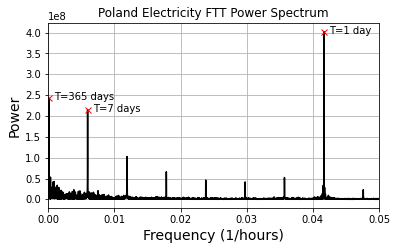

In [37]:
peaks, _ = signal.find_peaks(FFT_abs, threshold=9.5E6, distance=200)
widths = signal.peak_widths(FFT_abs, peaks, rel_height=0.97)

idxs = [0, 2, 8]
T = np.int32(np.around(1/f[peaks[idxs]]/24))

ax = latex_settings()

ax.plot(f[:n//2], FFT_abs[:n//2], 'k')

ax.plot(f[peaks[idxs]], FFT_abs[peaks[idxs]], 'x', c='red')

for i, t in zip(idxs, T):
    if i == 8:
        string = f'T={t} day'
    else:
        string = f'T={t} days'
    
    ax.annotate(string, xy=(f[peaks[i]], FFT_abs[peaks[i]]),
                    xytext=(f[peaks[i]]+0.0008, FFT_abs[peaks[i]] - 0.5E7))


plt.xlim(0, 0.05)
plt.xlabel('Frequency (1/hours)')
plt.ylabel('Power')
plt.grid()
plt.title('Poland Electricity FTT Power Spectrum')
if os.path.isfile('../Images/Poland_Spectrum.png'):
    pass
else:
    plt.savefig('../Images/Poland_Spectrum.png', dpi=800, transparent=True)

In [12]:
1/np.unique(np.abs(f[peaks]))/24

array([3.65333333e+02, 1.30476190e+01, 6.99574468e+00, 3.50159744e+00,
       2.33356991e+00, 1.74986695e+00, 1.39974457e+00, 1.16678495e+00,
       1.00000000e+00, 8.74933475e-01, 6.36346042e-01, 5.00000000e-01,
       4.66647743e-01, 3.33333333e-01, 2.50000000e-01, 2.00000000e-01])

In [13]:
1/f[np.argmax(FFT_abs)]

24.0

# Frequencies expressed in days 

In [14]:
T = 1 / (24 * np.unique(np.abs(freq[:])))
T

array([3288.        , 1644.        , 1096.        ,  822.        ,
        657.6       ,  548.        ,  469.71428571,  411.        ,
        365.33333333,  328.8       ,  298.90909091])

In [15]:
print(3288/365, "years") 

9.008219178082191 years


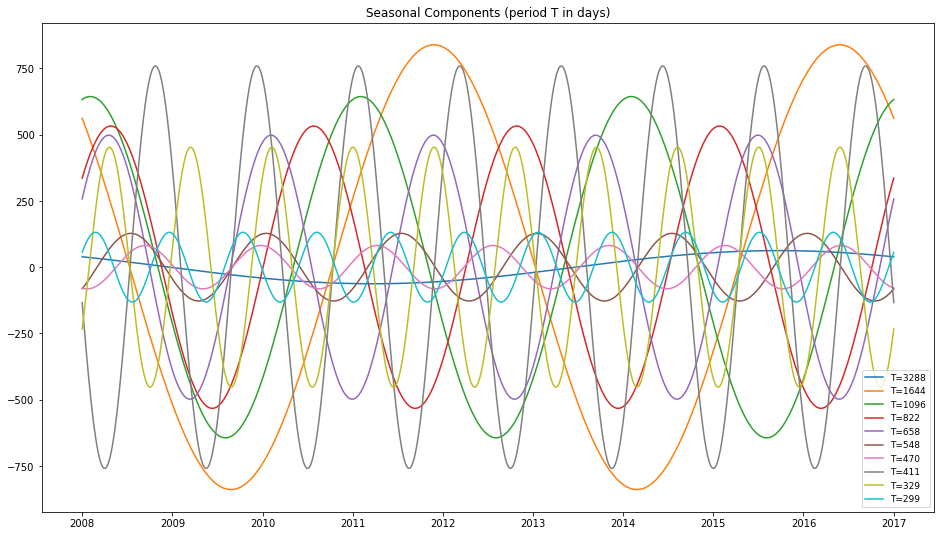

In [16]:
plt.figure(figsize=(16,9))#

mask = np.int32(T) != 365

for component, period in zip(Fourier_comp[mask], T[mask]):
    plt.plot(df.Date, component, label=f'T={period:.0f}')
    plt.title("Seasonal Components (period T in days)")
    plt.legend()

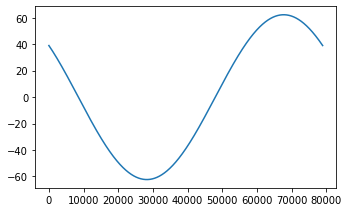

In [17]:
plt.plot(Fourier_comp[0])

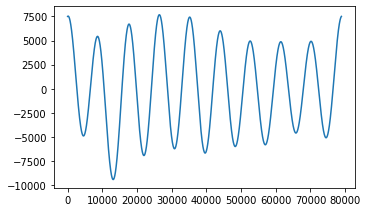

In [18]:
plt.plot(Fourier_comp.sum(axis=0))